In [1]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import time, os, sys
from tqdm import tqdm

from matplotlib import pyplot as plt
from utils.basic_utils import *
from utils.pricing import load_px_close, discret_rets, sample_wgts
from utils.pricing import dummy_col, rename_col, px_fwd_rets, px_mom_feats, px_mom_co_feats_light
from utils.pricing import eq_wgt_indices, to_index_form, get_symbol_pricing, get_return_intervals
from utils.fundamental import pipe_transform_df, chain_divide, chain_scale
from utils.fundamental import chain_outlier, chain_post_drop, chain_wide_transform
from utils.fundamental import chain_eps_estimates, chain_eps_revisions, chain_rec_trend
from utils.fundamental import load_append_ds, get_daily_ts, numeric_cols, filter_cols
from utils.fundamental import get_focus_tickers

from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.validation import column_or_1d
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support
from sklearn.metrics import precision_score, roc_auc_score

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, Adagrad, Adadelta, Adamax, Nadam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import CSVLogger

Loading utils/config.json


Using TensorFlow backend.


In [14]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
# feature mapping for different datasets
ds_dict = {
    'fin_data': {
        'path': 'summary-categories/financialData/',
        'index': 'storeDate',
        'features': [
            'numberOfAnalystOpinions', 'currentPrice', 'revenuePerShare', 'totalCashPerShare',
            'currentRatio', 'debtToEquity', 'earningsGrowth', 'ebitda', 
            'ebitdaMargins', 'freeCashflow', 'grossMargins', 
            'grossProfits', 'operatingCashflow', 'operatingMargins', 'profitMargins', 
            'quickRatio', 'recommendationMean', 
            'returnOnAssets', 'returnOnEquity', 'revenueGrowth', 
            'targetHighPrice', 'targetLowPrice', 'targetMeanPrice', 
            'targetMedianPrice', 'totalCash', 'totalDebt', 'totalRevenue', 
#             'financialCurrency', 'recommendationKey',              
            'symbol', ],
        'scale': [
            'freeCashflow', 'operatingCashflow', 'ebitda', 
            'totalCash', 'totalDebt', 'totalRevenue', 'grossProfits', ],
        'divide': ('currentPrice', 
                   ['revenuePerShare', 'totalCashPerShare', 
                    'targetLowPrice', 'targetMeanPrice', 
                    'targetMedianPrice', 'targetHighPrice', ]),
        'outlier': 'quantile',
        'post_drop': ['numberOfAnalystOpinions'],
    },    
    'key_statistics': {
        'path': 'summary-categories/defaultKeyStatistics/',
        'index': 'storeDate',
        'features': [
            'beta', 'earningsQuarterlyGrowth', 
            'enterpriseToEbitda', 'enterpriseToRevenue', 'enterpriseValue', 
            'netIncomeToCommon', 'pegRatio', 
            'shortPercentOfFloat', 'shortRatio', 'heldPercentInsiders', 
            'heldPercentInstitutions', 'symbol', ],
        'scale': ['enterpriseValue', 'netIncomeToCommon', ],
        'outlier': 'quantile', 
    },
    'day_quote': {
        'path': 'quote/csv/',
        'index': 'storeDate',
        'features': [
            'regularMarketChangePercent',
            'averageDailyVolume10Day', 'averageDailyVolume3Month', 'regularMarketVolume', 
            'fiftyDayAverageChangePercent', 'twoHundredDayAverageChangePercent',
            'fiftyTwoWeekHighChangePercent', 'fiftyTwoWeekLowChangePercent', 
            'forwardPE', 'trailingPE', 'priceToBook', 'marketCap', 'symbol', ],
        'scale': ['marketCap', ],
        'divide': ('regularMarketVolume', ['averageDailyVolume10Day', 'averageDailyVolume3Month']),
        'outlier': 4, 
    },        
    'eps_trend': {
        'path': 'summary-categories/epsTrend/',
        'index': 'storeDate',
        'periods': ['0y', '+1y', '+5y', '-5y'],        
        'features': [
            'period', 'growth', 
            'current', '7daysAgo', '30daysAgo', '60daysAgo', '90daysAgo', 
            'symbol', ],
        'pivot_cols': ['growth', 'current', '7daysAgo', '30daysAgo', '60daysAgo', '90daysAgo'],
        'outlier': 'quantile',
    },
    'eps_estimates': {
        'path': 'summary-categories/earningsEstimate/',
        'index': 'storeDate',
        'periods': ['0y', '+1y', '+5y', '-5y'],
        'features': ['period', 'avg', 'low', 'high', 'symbol', ],
        'pivot_cols': ['avg', 'low', 'high'],
        'outlier': 'quantile', 
    },
    'eps_revisions': {
        'path': 'summary-categories/epsRevisions/',
        'index': 'storeDate',
        'periods': ['0y', '+1y', '+5y', '-5y'],
        'features': [
            'period', 'growth', 'upLast7days', 'upLast30days', 'downLast30days', 
            'symbol', ],
        'pivot_cols': ['growth', 'upLast7days', 'upLast30days', 'downLast30days'],
        'outlier': 3, 
    },
    'spy_trend': {
        'path': 'summary-categories/indexTrend/',
        'index': 'storeDate',
        'features': [
            '0q', '+1q', '0y', '+1y', '+5y', '-5y', 
            'peRatio', 'pegRatio', 'symbol', ]
    },
    'net_purchase': {
        'path': 'summary-categories/netSharePurchaseActivity/',
        'index': 'storeDate',
        'features': [
            'netPercentInsiderShares', 'buyPercentInsiderShares', 'sellPercentInsiderShares', 
            'symbol', ]
    },    
    'rec_trend': {
        'path': 'summary-categories/recommendationTrend/',
        'index': 'storeDate',
        'periods': ['-1m', '-2m'],
        'features': [
            'period', 'strongBuy', 'buy', 'hold', 'sell', 'strongSell', 
            'symbol', ],
        'pivot_cols': ['strongBuy', 'buy', 'hold', 'sell', 'strongSell'],
        'outlier': 10,
    },
}

# pre-processing pipeline
fn_pipeline = {
    'fin_data': [chain_scale, chain_divide, chain_post_drop, chain_outlier],
    'key_statistics': [chain_scale, chain_outlier],
    'day_quote': [chain_divide, chain_scale, chain_outlier],
    'eps_trend': [chain_wide_transform, chain_eps_estimates, chain_outlier],
    'eps_estimates': [chain_wide_transform, chain_eps_estimates, chain_outlier],
#     'eps_revisions': [chain_wide_transform, chain_outlier],
#     'spy_trend':[lambda x, y: x],
#     'net_purchase':[lambda x, y: x],    
#     'rec_trend': [chain_wide_transform, chain_rec_trend, chain_outlier],
}

### Context data

In [28]:
# context data
bench = '^GSPC'
y_col = 'fwdReturn'
tickers = config['companies']

context = {
    'tickers': tickers,
    'fn_pipeline': fn_pipeline,
    'ml_path': '../ML/',
    'model_name': 'bottomup_TF.h5',
    'tmp_path': '../tmp/',
    'ds_name': 'co-bottomup-ds',
    'px_close': 'universe-px-ds',
    'trained_cols': 'bottomup_TF_train_cols.npy',
    'look_ahead': 20,
    'look_back': 252,
    'smooth_window': 10,
    'load_ds': True,
    'scale': True,
    'test_size': .05,
    'verbose': True,
    's3_path': f'recommend/bottomup_ML/',
    'verbose': 2,
    'units': 1000,
    'hidden_layers': 4,
    'max_iter': 400,
    'l2_reg': 0.5,
    'dropout': 0.5,
}

In [4]:
# get latest pricing file from inferece server
px_close_ds = context['px_close']
tmp_path = context['tmp_path']
os.makedirs(tmp_path, exist_ok=True)
!scp -i ~/.ssh/qc_infra.pem ubuntu@54.188.213.105:~/inception/tmp/{px_close_ds} {tmp_path}{px_close_ds}

universe-px-ds                                100%   18MB  17.8MB/s   00:00    


In [29]:
# load stored pricing
px_close = load_px_close(
    context['tmp_path'], context['px_close'], context['load_ds']).drop_duplicates()
print('px_close.info()', px_close.info())

stacked_px = px_close.stack().to_frame().rename(columns={0: 'close'}) # stack date + symbol
stacked_px.index.set_names(['storeDate', 'symbol'], inplace=True) # reindex
context['close_px'] = stacked_px

prices = px_close.dropna(subset=[bench])[tickers]
look_ahead = context['look_ahead']
# cut_range = get_return_intervals(prices, look_ahead, tresholds=[0.25, 0.75])
# hardcoded to narrow the range of recomendation in these limited dataset
cut_range = [ -np.inf, -0.13, -0.08,  0.1, 0.16, np.inf]
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]
f'Return intervals {np.round(cut_range, 2)}'

<class 'pandas.core.frame.DataFrame'>
Index: 4674 entries, 2004-05-09 to 2019-05-10
Columns: 1285 entries, 0700.HK to KRW=X
dtypes: float32(1285)
memory usage: 22.9+ MB
px_close.info() None


'Return intervals [ -inf -0.13 -0.08  0.1   0.16   inf]'

In [30]:
# latest quotes, profile, and industries
dates = read_dates('quote')
tgt_date = dates[-1] # last date saved in S3
print(f'Target date: {tgt_date}')

quotes = load_csvs('quote_consol', [tgt_date])
quotes.set_index('symbol', drop=False, inplace=True)

profile = load_csvs('summary_detail', ['assetProfile'])
profile.set_index('symbol', drop=False, inplace=True)

Target date: 2019-05-10
Loading file quote/csv/2019-05-10
Loading file summary-categories/assetProfile


In [31]:
# Smaller subset for testing
tgt_sectors = [
    'Technology',
    'Healthcare',
    'Industrials',
    'Basic Materials',
    'Consumer Cyclical',
    'Financial Services',
    'Consumer Defensive',
    'Real Estate',
    'Utilities',
    'Communication Services',
    'Energy',
]

# size_df = get_focus_tickers(quotes, profile, tgt_sectors)
# tickers = list(size_df.index)
# ind_count = size_df.groupby('industry').count()['marketCap']
# tgt_industries = list(ind_count.loc[ind_count > ind_count.median() - 1].index)
# tickers = list(profile.loc[profile.industry.isin(tgt_industries), 'symbol'])
tickers = list(quotes.loc[quotes.quoteType == 'EQUITY', 'symbol'])
context['tickers'] = tickers
print(f'{len(tickers)} companies')

1208 companies


### Final

In [8]:
def create_ds(context):
    # context variables
    key = context['key']
    load_ds = context['load_ds']
    load_dates = context['load_dates']
    tmp_path = context['tmp_path']
    
    # Load or append missing data to local dataset
    fname = tmp_path + key
    if load_ds & os.path.isfile(fname):
        daily_df = pd.read_parquet(fname)
        # compare and load missing dates
        missing_dates = list(
            set(daily_df.index.unique().date.astype(str))\
                .symmetric_difference(load_dates))
        if len(missing_dates) > 0: # retrieve missing dates
            append_df = get_daily_ts(key, ds_dict, missing_dates)
            daily_df = pd.concat([daily_df, append_df], axis=0) # append to daily
            # daily_df.drop_duplicates(inplace=True)
            daily_df.to_parquet(tmp_path + key) # and persist to drive for next time
    else:
        # file does not exist, retrieves all dates
        daily_df = get_daily_ts(key, ds_dict, load_dates)
        num_cols = excl(daily_df.columns, ['symbol', 'period'])
        daily_df.loc[:, num_cols] = daily_df[num_cols].astype(np.float32)
        # Make index a flat date, easier to index save down to drive if refresh pricing
        os.makedirs(tmp_path, exist_ok=True)
        # daily_df.drop_duplicates(inplace=True)
        daily_df.to_parquet(fname)
    daily_df.index.name = ds_dict[key]['index']
    daily_df.index = daily_df.index.date
    
    return daily_df

In [9]:
def pre_process_ds(context):
    
    # join all datasets
    tickers = context['tickers']
    sectors = profile.loc[profile.symbol.isin(tickers)].sector.unique()
    industries = profile.loc[profile.symbol.isin(tickers)].industry.unique()
    print(f'Sectors: {sectors.shape[0]}, Industries: {industries.shape[0]}')

    indices_df = pd.concat(
        [eq_wgt_indices(profile, px_close, 'sector', sectors, subset=tickers),
        eq_wgt_indices(profile, px_close, 'industry', industries, subset=tickers),
        to_index_form(px_close[bench], bench)], 
        axis=1).drop_duplicates()

    # generic price momentum statistics
    super_list = []
    for key in ('fin_data', 'key_statistics', 'day_quote', 'eps_trend', 'eps_estimates'):
        print(f'adding {key}')
        context['key'] = key
        context['pre'] = key.split('_')[0] # append preffix
        context['ds_dict'] = ds_dict[key]
        load_dates = read_dates(ds_dict[key]['path'], '.csv')
        context['load_dates'] = load_dates
        df = create_ds(context)
        df = df.loc[df.symbol.isin(tickers),:]
        processed_df = pipe_transform_df(df, key, fn_pipeline, context)
        if key in ('fin_data', 'key_statistics', 'day_quote'):
            processed_df.index.name = 'storeDate'
            processed_df = processed_df.reset_index().set_index(['storeDate', 'symbol'])
        super_list.append(processed_df.drop_duplicates())

    processed_df = pd.concat(super_list, axis=1)
    print(f'processed_df.shape {processed_df.shape}')

    # company specific statistics 
    tmp_path = context['tmp_path']
    ds_name = context['ds_name']

    super_list = []
    for i, ticker in tqdm(enumerate(tickers)):
        try:
            close = px_close[ticker].dropna()
            ft_df = px_mom_feats(close, ticker, incl_name=False)
            if ticker in profile.symbol.unique():
                top_groups = tuple([bench, profile.loc[ticker, 'sector']])
                co = px_mom_co_feats_light(close, indices_df, top_groups)
                ft_df = pd.concat([ft_df, co.loc[ft_df.index, :]], axis=1)
                ft_df.index.name = 'storeDate'
                super_list.append(ft_df.copy())
            else: print(ticker, 'missing profile, skipping')
        except Exception as e: 
            print("Exception: {0} {1}".format(ticker, e))

    px_mom_df = pd.concat(super_list, axis=0)

    px_mom_df = px_mom_df.reset_index().set_index(['storeDate', 'symbol']).sort_index().dropna()
    joined_df = pd.concat([processed_df, px_mom_df], join='inner', axis=1)
    print(f'joined_df.shape {joined_df.shape}')

    # basic scaling
    scale_on = context['scale']
    scaler = StandardScaler()
    num_cols = numeric_cols(joined_df)
    joined_df.loc[:, num_cols] = joined_df[num_cols].replace([np.inf, -np.inf, np.nan], 0)
    if scale_on: joined_df.loc[:, num_cols] = scaler.fit_transform(joined_df[num_cols])

    # add categoricals
    joined_df = dummy_col(joined_df, 'sector', shorten=True)
    
    return joined_df.reset_index('symbol')

In [10]:
def get_train_test_sets(context):

    verbose = context['verbose']
    ml_path, model_name = context['ml_path'], context['model_name']
    test_size = context['test_size']
    look_ahead, look_back, smooth_window = context['look_ahead'], context['look_back'], context['smooth_window']

    joined_df = pre_process_ds(context)

    # if we want to limit training set
    # index = joined_df.sort_index().index.unique()[-look_back:]
    # joined_df = joined_df.loc[index, :]
    # joined_df.shape

    # calculation of forward returns
    Y = px_close.loc[:, tickers].pct_change(look_ahead).shift(-look_ahead)
    Y = Y.rolling(smooth_window).mean() # smooth by the same length
    Y = Y[~(Y.isna().all(1))]
    Y = Y.loc[joined_df.index.unique(), :]

    # reshapes to include symbol in index in additional to date
    Y_df = Y.loc[joined_df.index.unique().sortlevel()[0], tickers]
    Y_df = Y_df.stack().to_frame().rename(columns={0: y_col})
    # somwhat repetitive with steps above but performs faster
    Y_df.index.set_names(['storeDate', 'symbol'], inplace=True)
    print('Y_df.shape', Y_df.shape)

    # re-index processed df on storeDate and symbol to have similar indices
    joined_df.index.set_names('storeDate', inplace=True)
    joined_df.set_index(['symbol'], append=True, inplace=True)
    print('joined_df.shape', joined_df.shape)

    # add Y values to processed df fast without having to loop
    joined_df.loc[:, y_col] = Y_df.loc[joined_df.index, y_col]

    # joined_df.loc[(slice(None), 'AAPL'), y_col].plot() # visualize smoothing
    # joined_df.groupby('symbol')[y_col].mean().sort_values() # rank long-term mean performance

    # discretize Y-variable
    joined_df.dropna(subset=[y_col], inplace=True)
    joined_df[y_col] = discret_rets(joined_df[y_col], cut_range, fwd_ret_labels)
    print('joined_df.shape', joined_df.shape)
    print(sample_wgts(joined_df[y_col]))

    joined_df.dropna(subset=[y_col], inplace=True)
    joined_df.loc[:, y_col] = joined_df[y_col].astype(str)

    days = len(joined_df.index.levels[0].unique())
    print(f'Training for {days} dates, {round(days/252, 1)} years')

    # joined_df.loc[(slice(None), 'TAL'), y_col].value_counts() # look at a specific security distribution
    train_df = joined_df.reset_index(drop=True)
    train_df.shape

    # create training and test sets
    X, y = train_df.drop(columns=y_col), train_df[y_col]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        break # just one split

    # skf = StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
    # for train_index, test_index in skf.split(X, y):
    #     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #     break

    return X_train, X_test, y_train, y_test

In [11]:
def train_ds(context):
    
    X_train, X_test, y_train, y_test = get_train_test_sets(context)

    # Keras Model
    units = context['units']
    max_iter = context['max_iter']
    l2_reg = context['l2_reg']
    dropout = context['dropout']
    trained_cols = context['trained_cols']

    y_train_oh = pd.get_dummies(y_train)[fwd_ret_labels]
    y_test_oh = pd.get_dummies(y_test)[fwd_ret_labels]

    # keras.regularizers.l2(l=0.001)

    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(units, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(int(units/2), activation='relu'))
    model.add(Dense(len(pd.unique(y_train)), activation='softmax'))

    ml_path, model_name = context['ml_path'], context['model_name']
    fname = ml_path + model_name

    es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=1)
    checkpointer = ModelCheckpoint(filepath=fname, verbose=1, save_best_only=True)
    csv_logger = CSVLogger('bottomup-train.log')

    opt = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit(
        X_train, y_train_oh, validation_data=(X_test, y_test_oh),
        epochs=max_iter, batch_size=200, callbacks=[es, checkpointer, csv_logger])

    score = model.evaluate(X_test, y_test_oh)
    print(f'Loss: {score[0]}, Accuracy: {score[1]}')

    # save training columns
    np.save(ml_path + trained_cols, X_train.columns) # save feature order
    print(f'X_train.shape {X_train.shape}, columns: {list(X_train.columns)}')
    print('Saved: ', ml_path + trained_cols)

    # save model to drive
    ml_path, model_name = context['ml_path'], context['model_name']
    fname = ml_path + model_name
    model.save(fname)
    print('Saved ', fname)

In [12]:
def predict_ds(context):
    
    ml_path = context['ml_path']
    model_name = context['model_name']
    trained_cols = context['trained_cols']

    joined_df = create_pre_process_ds(context)
    pred_X = joined_df.loc[joined_df.sort_index().index[-1], :]
    print('pred_X.shape', pred_X.shape)

    # ensure prediction dataset is consistent with trained model
    train_cols = np.load(ml_path + trained_cols) # save feature order
    missing_cols = [x for x in train_cols if x not in pred_X.columns]
    if len(missing_cols):
        print(f'Warning missing columns: {missing_cols}')
        pred_X = pd.concat([pred_X, pd.DataFrame(columns=missing_cols)], axis=1)
        pred_X[missing_cols] = 0

    sorted_cols = list(np.append(train_cols, ['symbol']))
    print('pred_X.shape', pred_X[sorted_cols].shape)

    pred_df = pd.DataFrame()
    pred_df['symbol'] = pred_X.symbol

    # Load model    
    fname = ml_path + model_name
    model = load_model(fname)
    print('Loaded', fname)

    preds = model.predict(pred_X[sorted_cols].iloc[:, :-1])
    preds_classes = model.predict_classes(pred_X[sorted_cols].iloc[:, :-1])    
    
    pred_df['pred_class'] = preds_classes
    pred_df['pred_label'] = list(map(lambda x: fwd_ret_labels[x], preds_classes))
    probs = np.round(preds,3)
    pred_prob = np.argmax(probs, axis=1)
    pred_df['confidence'] = [x[np.argmax(x)] for x in probs] # higest prob
    prob_df = pd.DataFrame(probs, index=pred_df.index, columns=fwd_ret_labels)
    pred_df = pd.concat([pred_df, prob_df[fwd_ret_labels]], axis=1)
    pred_df.index.name = 'pred_date'

    # store in S3
    s3_path = context['s3_path']
    s3_df = pred_df.reset_index(drop=False)
    rename_col(s3_df, 'index', 'pred_date')
    csv_store(s3_df, s3_path, csv_ext.format(tgt_date))
            
    return pred_df

#### Train

In [33]:
X_train, X_test, y_train, y_test = get_train_test_sets(context)

Sectors: 11, Industries: 136
adding fin_data
adding key_statistics
adding day_quote
adding eps_trend


/home/ubuntu/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:969: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


adding eps_estimates


0it [00:00, ?it/s]/home/ubuntu/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
1it [00:00,  7.43it/s]

processed_df.shape (102473, 67)


5it [00:00,  9.73it/s]

9984.T missing profile, skipping


18it [00:02,  8.66it/s]

ABMD missing profile, skipping


194it [00:25,  8.19it/s]

CBOE missing profile, skipping


305it [00:40,  9.31it/s]

DDD missing profile, skipping


332it [00:43,  8.48it/s]

DRE missing profile, skipping


534it [01:10,  8.90it/s]

IBKR missing profile, skipping


583it [01:17,  8.09it/s]

JBT missing profile, skipping


652it [01:26,  8.72it/s]

LRCX missing profile, skipping


798it [01:45,  8.77it/s]

ODFL missing profile, skipping


893it [01:57,  8.26it/s]

REGN missing profile, skipping


919it [02:00,  8.23it/s]

ROP missing profile, skipping


1018it [02:13,  8.79it/s]

TAP missing profile, skipping


1091it [02:23,  8.61it/s]

UDR missing profile, skipping


1175it [02:34,  8.74it/s]

WSM missing profile, skipping


1208it [02:39,  9.52it/s]


joined_df.shape (96290, 85)


/home/ubuntu/miniconda3/envs/inception/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ubuntu/miniconda3/envs/inception/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/ubuntu/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Y_df.shape (183023, 1)
joined_df.shape (96290, 95)


/home/ubuntu/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:969: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


joined_df.shape (77556, 96)
neutral    0.794007
short      0.074553
long       0.062716
bear       0.042563
bull       0.026162
Name: fwdReturn, dtype: float64
Training for 168 dates, 0.7 years


In [ ]:
# Keras Model
units = context['units']
max_iter = context['max_iter']
l2_reg = context['l2_reg']
dropout = context['dropout']
trained_cols = context['trained_cols']

y_train_oh = pd.get_dummies(y_train)[fwd_ret_labels]
y_test_oh = pd.get_dummies(y_test)[fwd_ret_labels]

# keras.regularizers.l2(l=0.001)

model = Sequential()
model.add(Dense(units, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(units, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(int(units/2), activation='relu'))
model.add(Dense(len(pd.unique(y_train)), activation='softmax'))

ml_path, model_name = context['ml_path'], context['model_name']
fname = ml_path + model_name

es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=1)
checkpointer = ModelCheckpoint(filepath=fname, verbose=1, save_best_only=True)
csv_logger = CSVLogger('bottomup-train.log')

opt = Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(
    X_train, y_train_oh, validation_data=(X_test, y_test_oh),
    epochs=max_iter, batch_size=200, callbacks=[es, checkpointer, csv_logger])

score = model.evaluate(X_test, y_test_oh)
print(f'Loss: {score[0]}, Accuracy: {score[1]}')

# save training columns
np.save(ml_path + trained_cols, X_train.columns) # save feature order
print(f'X_train.shape {X_train.shape}, columns: {list(X_train.columns)}')
print('Saved: ', ml_path + trained_cols)

# save model to drive
ml_path, model_name = context['ml_path'], context['model_name']
fname = ml_path + model_name
model.save(fname)
print('Saved ', fname)

Train on 73678 samples, validate on 3878 samples
Epoch 1/400
73678/73678 [==============================] - 8s 106us/step - loss: 0.7124 - acc: 0.7916 - val_loss: 0.6571 - val_acc: 0.7940

Epoch 00001: val_loss improved from inf to 0.65707, saving model to ../ML/bottomup_TF.h5
Epoch 2/400
73678/73678 [==============================] - 7s 93us/step - loss: 0.6459 - acc: 0.7945 - val_loss: 0.6041 - val_acc: 0.7968

Epoch 00002: val_loss improved from 0.65707 to 0.60414, saving model to ../ML/bottomup_TF.h5
Epoch 3/400
73678/73678 [==============================] - 7s 94us/step - loss: 0.6112 - acc: 0.7967 - val_loss: 0.5772 - val_acc: 0.7976

Epoch 00003: val_loss improved from 0.60414 to 0.57718, saving model to ../ML/bottomup_TF.h5
Epoch 4/400
73678/73678 [==============================] - 7s 94us/step - loss: 0.5908 - acc: 0.7971 - val_loss: 0.5608 - val_acc: 0.8022

Epoch 00004: val_loss improved from 0.57718 to 0.56077, saving model to ../ML/bottomup_TF.h5
Epoch 5/400
73678/73678 [=

In [108]:
%time train_ds(context)

Sectors: 11, Industries: 72
adding fin_data
adding key_statistics
adding day_quote
adding eps_trend
adding eps_estimates


0it [00:00, ?it/s]/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
2it [00:00, 14.30it/s]

processed_df.shape (85022, 67)


1006it [01:24, 11.97it/s]


joined_df.shape (80729, 85)


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Y_df.shape (149548, 1)
joined_df.shape (80729, 95)


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:969: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


joined_df.shape (64943, 96)
neutral   0.78
short     0.08
long      0.06
bear      0.05
bull      0.03
Name: fwdReturn, dtype: float64
Training for 165 dates, 0.7 years
Epoch 1/50
51954/51954 [==============================] - 4s 78us/step - loss: 0.7242 - acc: 0.7689
Epoch 2/50
51954/51954 [==============================] - 3s 57us/step - loss: 0.6148 - acc: 0.7890
Epoch 3/50
51954/51954 [==============================] - 3s 57us/step - loss: 0.5549 - acc: 0.8031
Epoch 4/50
51954/51954 [==============================] - 3s 57us/step - loss: 0.4969 - acc: 0.8183
Epoch 5/50
51954/51954 [==============================] - 3s 57us/step - loss: 0.4406 - acc: 0.8334
Epoch 6/50
51954/51954 [==============================] - 3s 57us/step - loss: 0.3851 - acc: 0.8534
Epoch 7/50
51954/51954 [==============================] - 3s 57us/step - loss: 0.3407 - acc: 0.8688
Epoch 8/50
51954/51954 [==============================] - 3s 57us/step - loss: 0.3004 - acc: 0.8834
Epoch 9/50
51954/51954 [=======

#### Predict

In [ ]:
ml_path = context['ml_path']
model_name = context['model_name']
trained_cols = context['trained_cols']

joined_df = create_pre_process_ds(context)
pred_X = joined_df.loc[joined_df.sort_index().index[-1], :]
print('pred_X.shape', pred_X.shape)

# ensure prediction dataset is consistent with trained model
train_cols = np.load(ml_path + trained_cols) # save feature order
missing_cols = [x for x in train_cols if x not in pred_X.columns]
if len(missing_cols):
    print(f'Warning missing columns: {missing_cols}')
    pred_X = pd.concat([pred_X, pd.DataFrame(columns=missing_cols)], axis=1)
    pred_X[missing_cols] = 0

sorted_cols = list(np.append(train_cols, ['symbol']))
print('pred_X.shape', pred_X[sorted_cols].shape)

In [74]:
pred_df = pd.DataFrame()
pred_df['symbol'] = pred_X.symbol

# Load model    
fname = ml_path + model_name
model = load_model(fname)
print('Loaded', fname)

Loaded ../ML/bottomup_TF.h5


In [75]:
preds = model.predict(pred_X[sorted_cols].iloc[:, :-1])
preds_classes = model.predict_classes(pred_X[sorted_cols].iloc[:, :-1])

In [76]:
# np.round(preds,3), preds_classes, list(map(lambda x: fwd_ret_labels[x], preds_classes))

In [77]:
pred_df['pred_class'] = preds_classes
pred_df['pred_label'] = list(map(lambda x: fwd_ret_labels[x], preds_classes))
probs = np.round(preds,3)
pred_prob = np.argmax(probs, axis=1)
pred_df['confidence'] = [x[np.argmax(x)] for x in probs] # higest prob
prob_df = pd.DataFrame(probs, index=pred_df.index, columns=fwd_ret_labels)
pred_df = pd.concat([pred_df, prob_df[fwd_ret_labels]], axis=1)
pred_df.index.name = 'pred_date'

In [78]:
pred_df

,symbol,pred_class,pred_label,confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,
2019-05-08,AUO,0,bear,0.96,0.96,0.04,0.00,0.00,0.00
2019-05-08,ARW,2,neutral,1.00,0.00,0.00,1.00,0.00,0.00
2019-05-08,ADBE,2,neutral,0.99,0.00,0.01,0.99,0.00,0.00
2019-05-08,AAPL,2,neutral,1.00,0.00,0.00,1.00,0.00,0.00
2019-05-08,ADI,2,neutral,1.00,0.00,0.00,1.00,0.00,0.00
2019-05-08,ADSK,2,neutral,1.00,0.00,0.00,1.00,0.00,0.00
2019-05-08,0700.HK,2,neutral,1.00,0.00,0.00,1.00,0.00,0.00
2019-05-08,ALRM,2,neutral,1.00,0.00,0.00,1.00,0.00,0.00
2019-05-08,ASX,2,neutral,1.00,0.00,0.00,1.00,0.00,0.00


In [18]:
%time pred_df = predict_ds(context)

Sectors: 1, Industries: 10
adding fin_data
Loading file summary-categories/financialData/2019-05-08
adding key_statistics
Loading file summary-categories/defaultKeyStatistics/2019-05-08
adding day_quote
Loading file quote/csv/2019-05-08
adding eps_trend
Loading file summary-categories/epsTrend/2019-05-08


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:969: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


adding eps_estimates
Loading file summary-categories/earningsEstimate/2019-05-08


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

0it [00:00, ?it/s]/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
2it [00:00, 13.23it/s]

processed_df.shape (3560, 67)


30it [00:02, 11.27it/s]


joined_df.shape (3277, 85)
pred_X.shape (28, 86)
Warning missing columns: ['^BASI_MATE', '^COMM_SERV', '^CONS_CYCL', '^CONS_DEFE', '^ENER', '^FINA_SERV', '^HEAL', '^INDU', '^REAL_ESTA', '^UTIL']
pred_X.shape (28, 96)
Instructions for updating:
Colocations handled automatically by placer.


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Instructions for updating:
Use tf.cast instead.
Loaded ../ML/bottomup_TF.h5
Saved recommend/bottomup_ML/2019-05-08.csv
CPU times: user 17 s, sys: 1.17 s, total: 18.2 s
Wall time: 11.1 s


#### Store / Read S3

In [64]:
s3_path = context['s3_path']

In [65]:
# read from S3
pred_df = pd.read_csv(
    csv_load(f'{s3_path}{tgt_date}'), 
    index_col='pred_date', parse_dates=True)

In [79]:
# store in S3
s3_path = context['s3_path']
s3_df = pred_df.reset_index(drop=False)
rename_col(s3_df, 'index', 'pred_date')
csv_store(s3_df, s3_path, csv_ext.format(tgt_date))

Saved recommend/bottomup_ML/2019-05-08.csv


#### Visualize

In [61]:
pred_df.head()

,symbol,pred_class,pred_label,confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,
2019-05-07,AWR,2,neutral,1.00,0.00,0.00,1.00,0.00,0.00
2019-05-07,MANT,2,neutral,1.00,0.00,0.00,1.00,0.00,0.00
2019-05-07,AME,2,neutral,1.00,0.00,0.00,1.00,0.00,0.00
2019-05-07,FL,2,neutral,0.82,0.00,0.18,0.82,0.00,0.00
2019-05-07,ADS,1,short,0.94,0.00,0.94,0.01,0.04,0.00


In [62]:
# recommendation distribution
pd.value_counts(pred_df.pred_label)

neutral    1050
short        58
bear         25
long         12
bull          3
Name: pred_label, dtype: int64

In [63]:
# top 3 picks by label
label_mask = pred_df.pred_label.isin(['bear', 'short', 'long', 'bull'])
pred_df.loc[label_mask]\
    .sort_values(by='confidence', ascending=False)\
    .groupby(by='pred_label').head(5)\
    .sort_values(by='pred_label')

,symbol,pred_class,pred_label,confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,
2019-05-07,VIPS,0,bear,1.00,1.00,0.00,0.00,0.00,0.00
2019-05-07,LFUS,0,bear,0.99,0.99,0.00,0.01,0.00,0.00
2019-05-07,IQ,0,bear,1.00,1.00,0.00,0.00,0.00,0.00
2019-05-07,SOGO,0,bear,0.99,0.99,0.01,0.00,0.00,0.00
2019-05-07,BLKB,0,bear,0.99,0.99,0.00,0.00,0.00,0.00
2019-05-07,NCR,4,bull,0.89,0.00,0.00,0.11,0.00,0.89
2019-05-07,DLPH,4,bull,0.99,0.00,0.00,0.00,0.00,0.99
2019-05-07,ITRI,4,bull,0.52,0.00,0.00,0.00,0.48,0.52
2019-05-07,CMC,3,long,1.00,0.00,0.00,0.00,1.00,0.00


### Other experiments 

#### Visualize sectors and industry groups

In [265]:
tgt_sectors = [
        'Technology',
        'Communication Services',
        'Healthcare',
        'Consumer Cyclical',
        'Consumer Defensive',
        'Industrials'
        ]

size_df = get_focus_tickers(quotes, profile, tgt_sectors)
ind_count = size_df.groupby('industry').count()['marketCap']
tgt_industries = list(ind_count.loc[ind_count > ind_count.median() - 1].index)

/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


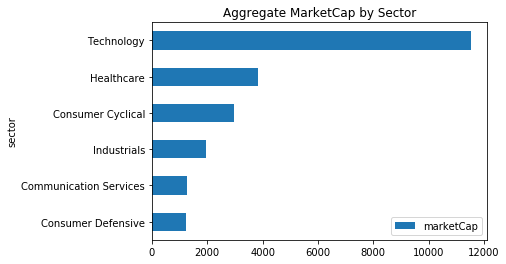

In [266]:
size_df.loc[tickers].groupby(by='sector').sum().sort_values('marketCap')\
    .plot(kind='barh', title='Aggregate MarketCap by Sector')

,sum,count
count,26.00,26.00
mean,874.59,19.54
std,"1,290.83",8.88
min,82.50,11.00
25%,290.61,13.00
50%,486.00,16.50
75%,"1,096.08",23.50
max,"6,613.73",50.00


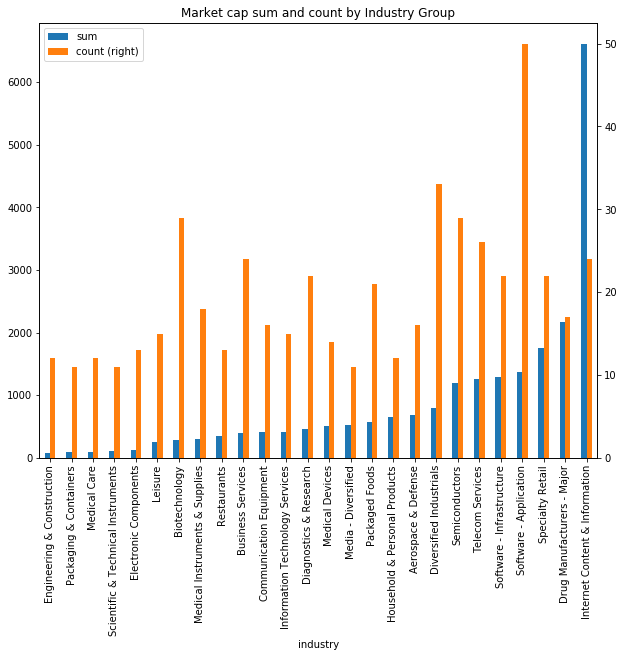

In [267]:
ind_group = size_df.loc[tickers].groupby(by='industry')
sorting_df = ind_group.agg(['sum', 'count'])['marketCap'].sort_values(by='sum')
sorting_df.plot(
    kind='bar', figsize=(10,8), secondary_y='count', 
    title='Market cap sum and count by Industry Group')
sorting_df.describe()

In [271]:
size_df.loc[tickers].groupby(by=['sector', 'industry']).agg(['count', 'sum'])

marketCap         
                                                              count      sum
sector                 industry                                             
Communication Services Telecom Services                          26 1,254.65
Consumer Cyclical      Leisure                                   15   250.52
                       Media - Diversified                       11   518.52
                       Packaging & Containers                    11    92.80
                       Restaurants                               13   348.53
                       Specialty Retail                          22 1,748.01
Consumer Defensive     Household & Personal Products             12   650.84
                       Packaged Foods                            21   568.77
Healthcare             Biotechnology                             29   288.36
                       Diagnostics & Research                    22   459.85
                       Drug Manufacturers - Major                17 2,174.09
                       Medical Care                              12    96.58
                       Medical Devices                           14   512.16
                       Medical Instruments & Supplies            18   297.37
Industrials            Aerospace & Defense                       16   678.76
                       Business Services                         24   392.64
                       Diversified Industrials                   33   796.75
                       Engineering & Construction                12    82.50
Technology             Communication Equipment                   16   414.94
                       Electronic Components                     13   123.75
                       Information Technology Services           15   418.12
                       Internet Content & Information            24 6,613.73
                       Scientific & Technical Instruments        11   108.42
                       Semiconductors                            29 1,195.86
                       Software - Application                    50 1,366.10
                       Software - Infrastructure                 22 1,286.67

#### Understand price changes across universe

In [317]:
sector_mapper = {
    s: list(size_df.loc[
            size_df.index.isin(tickers) 
            & (size_df.sector == 'Technology')].index)
    for s in tgt_sectors}

In [273]:
from utils.pricing import get_ind_index

tail = 90
Y = get_ind_index(px_close.dropna(subset=['^GSPC'])[tickers], tail=tail) - 1

In [274]:
indices_df = pd.concat(
    [eq_wgt_indices(profile, px_close, 'sector', tgt_sectors, subset=tickers, tail=tail),
    eq_wgt_indices(profile, px_close, 'industry', tgt_industries, subset=tickers, tail=tail),
    to_index_form(px_close[bench].tail(tail), bench)], axis=1).drop_duplicates() - 1

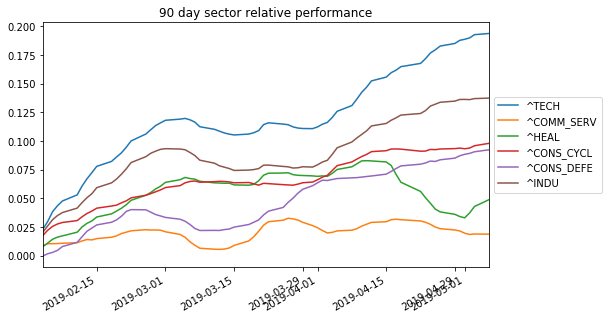

In [275]:
from utils.pricing import shorten_name

loc, margin = 'center left', (1, 0.5)

sect_idx = indices_df[[shorten_name(x) for x in tgt_sectors]].rolling(10).mean().dropna()
ax = sect_idx.plot(figsize=(8,5), title=f'{tail} day sector relative performance')
ax.legend(loc=loc, bbox_to_anchor=margin)

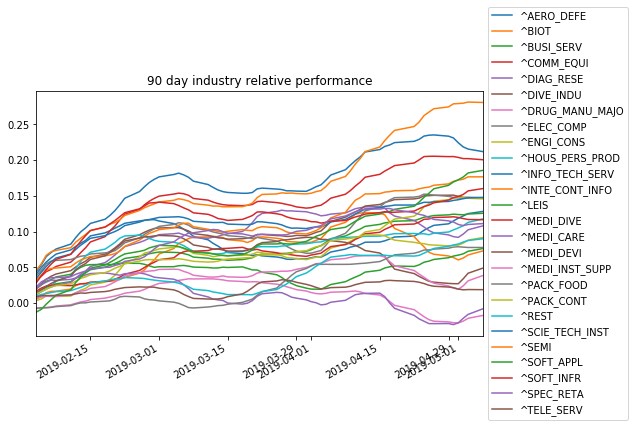

In [318]:
ind_idx = indices_df[
    [shorten_name(x) for x in tgt_industries]]\
    .rolling(10).mean().dropna()
ax = ind_idx.plot(figsize=(8,5), title=f'{tail} day industry relative performance')
ax.legend(loc=loc, bbox_to_anchor=margin)

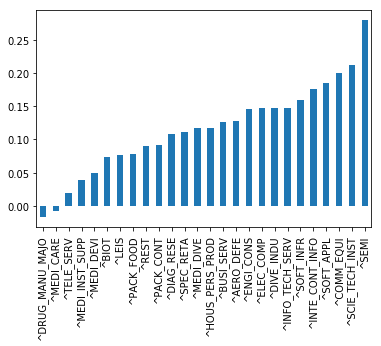

In [307]:
ind_idx.iloc[-1].sort_values().plot(kind='bar')

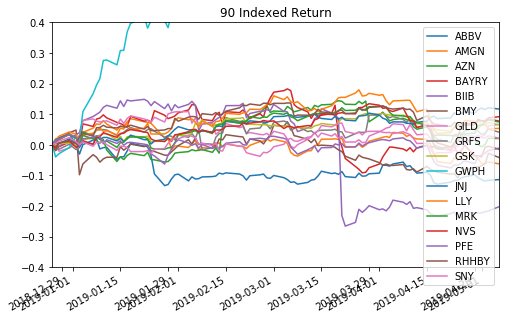

In [320]:
see_industry = 'Drug Manufacturers - Major'
see_tickers = list(size_df.loc[size_df.index.isin(tickers) & (size_df.industry == see_industry)].index)

Y[see_tickers].plot(
    figsize=(8,5), 
    title=f'{tail} Indexed Return',
    ylim=(-.4, 0.4))
ax.legend(loc=loc, bbox_to_anchor=margin)

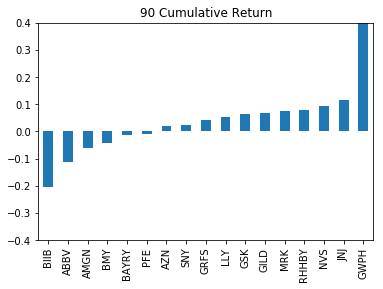

In [321]:
Y[see_tickers].iloc[-1].sort_values().plot(
    kind='bar',
    title=f'{tail} Cumulative Return',
    ylim=(-.4, 0.4))

#### Remove price outliers

In [ ]:
y_outliers = Y.loc[(Y > 1).any(1).values, (Y > 1).any().loc[(Y > 1).any()].index]
y_outliers.max().sort_values()

#### Old training

In [18]:
features = X_train.shape[1]

# RandomForestClassifier
params = {
    'n_estimators': 50, 'max_features': features, 'max_depth': 30,
    'min_samples_split': 2, 
    'random_state': 1, 'n_jobs': -1}

rfc = RandomForestClassifier(**params).fit(X_train, y_train)
scores = rfc.score(X_train, y_train), rfc.score(X_test, y_test)
print(scores)

(0.9960288141854451, 0.6626038781163435)


In [19]:
# ExtraTreesClassifier
params = {
    'n_estimators': 50, 'max_depth': 30,
    'min_samples_split': 2, 'min_samples_leaf': 1,
    'random_state': None, 'n_jobs': -1}

etc = ExtraTreesClassifier(**params).fit(X_train, y_train)
scores = etc.score(X_train, y_train), etc.score(X_test, y_test)
print(scores)

(0.9970908755079424, 0.6587257617728531)


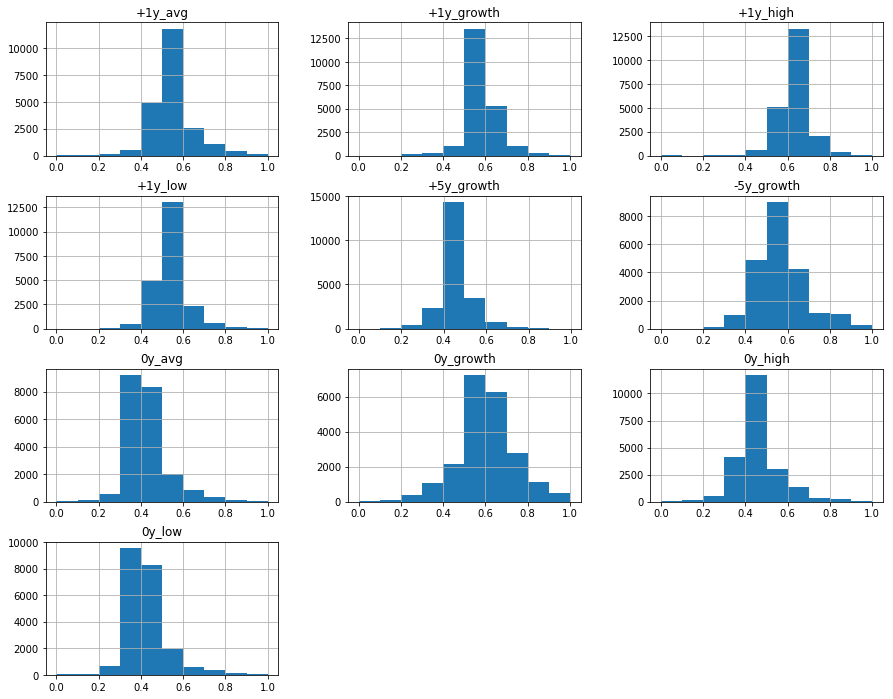

In [20]:
X_train.hist(figsize=(15,12));

In [21]:
%%time
# MLPClassifier
params = {
    'solver': 'lbfgs', 'max_iter': 200, 'activation': 'relu', 
    'alpha': 0.001, 'hidden_layer_sizes': (features - 1, 5),
    'learning_rate': 'adaptive', 'random_state': None, 'verbose': True,}

mlpc = MLPClassifier(**params).fit(X_train, y_train)
scores = mlpc.score(X_train, y_train), mlpc.score(X_test, y_test)
print(scores)

(0.3139083856667898, 0.31560480147737763)
CPU times: user 6.74 s, sys: 982 ms, total: 7.72 s
Wall time: 1.36 s


#### Metrics

Feature ranking:
39 feature fiftyDayAverageChangePercent (0.13894538386557223)
72 feature PctMA50 (0.11254266927461412)
75 feature PctChg20 (0.08822558257358028)
80 feature rsBench20 (0.07213953982565484)
74 feature RollVol30 (0.03496587366055478)
81 feature rsSect20 (0.0340876024919688)
82 feature rsBench60 (0.02319553684016019)
76 feature PctChg60 (0.020830627535985337)
40 feature twoHundredDayAverageChangePercent (0.01623283841357299)
79 feature Pct52WkL (0.01618768652281214)
78 feature Pct52WkH (0.011043691127340506)
42 feature fiftyTwoWeekLowChangePercent (0.010764093819782444)
83 feature rsSect60 (0.010656604533140282)
41 feature fiftyTwoWeekHighChangePercent (0.0100273480163043)
77 feature PctChg120 (0.00998784329517619)
85 feature rsSect120 (0.009201565248485508)
84 feature rsBench120 (0.00897199388455194)
21 feature targetMedianPrice (0.008523793075843038)
45 feature priceToBook (0.008500119154014687)
73 feature PctMA200 (0.008238867781577274)
46 feature marketCap (0.008137165

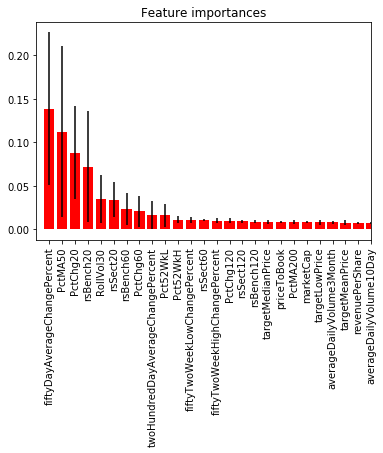

In [625]:
show_fi(clf1, X_train, 25)

In [626]:
print('Confussion Matrix\n', confusion_matrix(clf1.predict(X_test), y_test, labels=fwd_ret_labels))

Confussion Matrix
 [[   44     6     0     0     0]
 [   13  1025   144     2     0]
 [    0   381 11020   297     5]
 [    0     0   237  1334    16]
 [    0     0     0    10    50]]


In [627]:
print('Classificaton report\n', classification_report(clf1.predict(X_test), y_test, target_names=fwd_ret_labels))

Classificaton report
               precision    recall  f1-score   support

        bear       0.77      0.88      0.82        50
       short       0.70      0.83      0.76        60
     neutral       0.81      0.84      0.83      1587
        long       0.97      0.94      0.95     11703
        bull       0.73      0.87      0.79      1184

   micro avg       0.92      0.92      0.92     14584
   macro avg       0.80      0.87      0.83     14584
weighted avg       0.93      0.92      0.93     14584



In [629]:
log_loss(y_test, clf1.predict_proba(X_test))

0.3642648577874384

#### Gridsearches

In [ ]:
# np.arange(10, X.shape[1], int(X.shape[1]*.25))

In [ ]:
# %%time
# # GridSearchCV for RandomForestClassifier
# parameters = {
#     'n_estimators': [10, 40, 80], 
#     'max_features': np.arange(10, X.shape[1], int(X.shape[1]*.25)), 
#     'random_state': np.arange(1, 10, 3)}

# # parameters = {
# #     'n_estimators': [40], 
# #     'max_features': [30], 
# #     'random_state': [1]}

# clf = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1, cv=5)
# clf.fit(X_train, y_train)

# print(clf.score(X_train, y_train), clf.score(X_test, y_test))
# print(clf.best_params_)

In [ ]:
# %%time
# # GridSearchCV for MLPClassifier

# parameters = {
#     'solver': ['lbfgs'], # ['lbfgs', 'sgd', 'adam']
#     'max_iter': [200], # [200, 400, 600]
#     'activation': ['relu'], # ['logistic', 'tanh', 'relu']
#     'alpha': 10.0 ** -np.arange(2, 5, 1), # 10.0 ** -np.arange(2, 5, 1)
#     'learning_rate' : ['adaptive'], # ['constant', 'adaptive']
#     'hidden_layer_sizes': np.arange(5, 50, 10), # np.arange(5, 50, 10)
#     'random_state': np.arange(0, 10, 3)} # np.arange(0, 10, 2)

# parameters = {
#     'solver': ['lbfgs'], 
#     'max_iter': [200], 
#     'activation': ['relu'], 
#     'alpha': [0.01], 
#     'learning_rate' : ['adaptive'], # ['constant', 'adaptive']
#     'hidden_layer_sizes': [ 45 ], # np.arange(5, 50, 10)
#     'random_state': [0] } # np.arange(0, 10, 2)

# clf = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, cv=5)
# clf.fit(X_train, y_train)

# scores = clf.score(X_train, y_train), clf.score(X_test, y_test)
# print(scores)
# print(clf.best_params_)